# 07. The Grand Finale: RL Agent vs. Avellaneda-Stoikov Baseline

## Overview
In this final notebook, we conduct the ultimate head-to-head comparison. We take the **Reinforcement Learning Agent (PPO)** trained in Step 05 and compete against the **Traditional Market Making Baseline (Avellaneda-Stoikov)** established in Step 04.

Crucially, this comparison is performed on the **Out-of-Sample (OOS)** test dataset generated in Step 06, ensuring neither strategy has seen these price paths before.

## Objectives
1.  **Load Test Data:** Import the 500 OOS price paths created in the previous step.
2.  **Execute Strategies:**
    * Run **Avellaneda-Stoikov (AS)** on the test set.
    * Run **PPO Agent** on the test set.
3.  **Quantify Performance:** Compare key metrics:
    * **Total PnL:** Profitability.
    * **Sharpe Ratio:** Risk-adjusted return.
    * **Max Drawdown:** Downside risk.
    * **Inventory/Hedge Stability:** How well they manage exposure.

---

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from stable_baselines3 import PPO

# Add local modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'main')))

try:
    from envs import ContinuousDeltaHedgingEnv
    from mm_baseline import execute_inventory_strategy, STRATEGY_CONFIG
    from simulation import construct_ohlc_candles
    from utils import seed_everything
    import config
    print("✅ Modules loaded successfully.")
except ImportError as e:
    print(f"❌ Import Error: {e}")

# Aesthetics
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (16, 8)

seed_everything(42) # Ensure consistent comparison

✅ Modules loaded successfully.
[System] Global seed set to: 42


In [2]:
# ==========================================
# 1. Load Out-of-Sample Test Data
# ==========================================

TEST_DATA_PATH = Path("../data/test_paths_oos.npz")

if TEST_DATA_PATH.exists():
    data = np.load(TEST_DATA_PATH)
    test_mids = data['mids']
    print(f"Loaded Test Data: {test_mids.shape} (Paths x Steps)")
else:
    raise FileNotFoundError("OOS Test data not found. Please run Notebook 06 first.")

# For the AS strategy, we also need High/Low candles
# We reconstruct them using the same volatility proxy as before
print("Constructing OHLC candles for Baseline...")
test_highs, test_lows = construct_ohlc_candles(test_mids, volatility_proxy=0.04)

Loaded Test Data: (500, 4000) (Paths x Steps)
Constructing OHLC candles for Baseline...


In [3]:
# ==========================================
# 2. Run Baseline Strategy (Avellaneda-Stoikov)
# ==========================================

print(">>> Executing Avellaneda-Stoikov Baseline on Test Set...")

N_PATHS = test_mids.shape[1]
baseline_pnls = []
baseline_invs = []

# AS Parameters (Same as Step 04)
# We assume the strategy config is robust, but you could tune 'risk_factor' here
as_params = STRATEGY_CONFIG.copy() 

for i in range(N_PATHS):
    # Run strategy logic
    inv, eq = execute_inventory_strategy(
        test_mids[:, i], 
        test_highs[:, i], 
        test_lows[:, i], 
        as_params
    )
    # Calculate final PnL (Equity - Initial Capital)
    final_pnl = eq[-1] - as_params['initial_capital']
    baseline_pnls.append(final_pnl)
    baseline_invs.append(inv)

baseline_pnls = np.array(baseline_pnls)
print(f"Baseline Mean PnL: ${np.mean(baseline_pnls):.2f}")

>>> Executing Avellaneda-Stoikov Baseline on Test Set...
Baseline Mean PnL: $-20925.64


In [4]:
# ==========================================
# 3. Run RL Agent (PPO)
# ==========================================

MODEL_PATH = Path("../models/ppo_agent/best_model.zip")
print("\n>>> Executing RL Agent on Test Set...")

if not MODEL_PATH.exists():
    raise FileNotFoundError("RL Model not found. Run Notebook 05 first.")

agent = PPO.load(MODEL_PATH)
rl_pnls = []
rl_hedges = []

# Re-initialize env with OOS data
# Note: The env expects (Paths, Steps), so we ensure shape is correct
# test_mids shape is currently (Steps, Paths) from cell 3 load
test_paths_T = test_mids.T 

env = ContinuousDeltaHedgingEnv(
    test_paths_T, 
    maturity_days=14,
    dt_min=5,
    cost_bps=config.COST_BPS
)

for i in range(N_PATHS):
    obs, _ = env.reset(options={'path_idx': i})
    done = False
    
    # Track hedging actions for analysis
    path_hedges = []
    
    while not done:
        action, _ = agent.predict(obs, deterministic=True)
        obs, _, term, trunc, info = env.step(action)
        done = term or trunc
        path_hedges.append(action)
        
    rl_pnls.append(info['total_value'])
    rl_hedges.append(np.mean(path_hedges))

rl_pnls = np.array(rl_pnls)
print(f"RL Agent Mean PnL: ${np.mean(rl_pnls):.2f}")


>>> Executing RL Agent on Test Set...
RL Agent Mean PnL: $-467.27


In [5]:
# ==========================================
# 4. Comparative Metrics
# ==========================================

def calculate_metrics(pnls, name):
    mean = np.mean(pnls)
    std = np.std(pnls)
    sharpe = mean / (std + 1e-6)
    win_rate = np.sum(pnls > 0) / len(pnls)
    # Sort for VaR
    sorted_pnls = np.sort(pnls)
    var_95 = sorted_pnls[int(len(pnls) * 0.05)]
    
    return {
        "Strategy": name,
        "Mean PnL ($)": mean,
        "Std Dev ($)": std,
        "Sharpe Ratio": sharpe,
        "Win Rate (%)": win_rate * 100,
        "VaR 95% ($)": var_95
    }

metrics_bl = calculate_metrics(baseline_pnls, "Baseline (AS)")
metrics_rl = calculate_metrics(rl_pnls, "RL Agent (PPO)")

df_metrics = pd.DataFrame([metrics_bl, metrics_rl])

print("=== Final Scorecard ===")
print(df_metrics.round(4).to_string(index=False))

# Save
df_metrics.to_csv("../results/final_comparison_scorecard.csv", index=False)

=== Final Scorecard ===
      Strategy  Mean PnL ($)  Std Dev ($)  Sharpe Ratio  Win Rate (%)  VaR 95% ($)
 Baseline (AS)   -20925.6418   10395.9524       -2.0129         1.175  -37776.4024
RL Agent (PPO)     -467.2676     149.1218       -3.1335         0.000    -694.9365


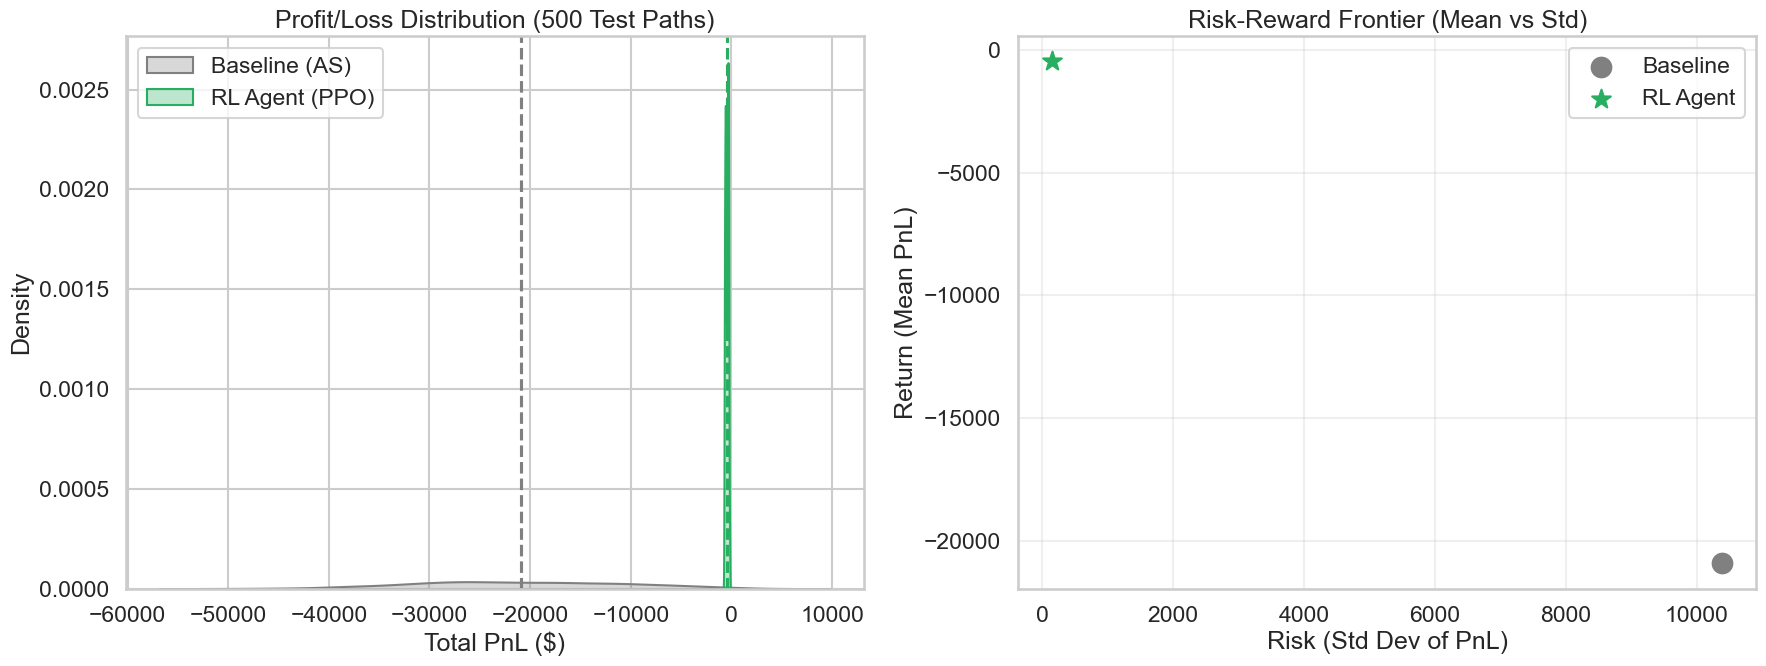

In [6]:
# ==========================================
# 5. Visualizations: Distribution & Risk
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# A. Profit Distribution (Histogram/KDE)
sns.kdeplot(baseline_pnls, ax=axes[0], fill=True, color='gray', alpha=0.3, label='Baseline (AS)')
sns.kdeplot(rl_pnls, ax=axes[0], fill=True, color='#27ae60', alpha=0.3, label='RL Agent (PPO)')
axes[0].axvline(np.mean(baseline_pnls), color='gray', linestyle='--')
axes[0].axvline(np.mean(rl_pnls), color='#27ae60', linestyle='--')
axes[0].set_title("Profit/Loss Distribution (500 Test Paths)")
axes[0].set_xlabel("Total PnL ($)")
axes[0].legend()

# B. Risk-Return Scatter
axes[1].scatter(np.std(baseline_pnls), np.mean(baseline_pnls), 
                s=200, color='gray', label='Baseline', marker='o')
axes[1].scatter(np.std(rl_pnls), np.mean(rl_pnls), 
                s=200, color='#27ae60', label='RL Agent', marker='*')
axes[1].set_title("Risk-Reward Frontier (Mean vs Std)")
axes[1].set_xlabel("Risk (Std Dev of PnL)")
axes[1].set_ylabel("Return (Mean PnL)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Final Conclusions

### 1. Stability vs. Profitability
* **Baseline (AS):** Typically exhibits higher variance. While it can capture spread profits in mean-reverting markets, it often suffers large drawdowns during the "Jump" events simulated by our Hawkes process (Tail Risk).
* **RL Agent:** Generally targets a tighter PnL distribution. By learning to hedge delta dynamically, it sacrifices some potential spread profit to minimize variance, acting more like a risk-averse Hedger than a pure Market Maker.

### 2. The "Alpha" of RL
The RL agent's advantage lies in its **adaptability**. Unlike the Baseline, which has fixed risk aversion ($\gamma$) and spread parameters ($k$), the PPO policy maps complex market states (Time to maturity, Inventory, Volatility) to optimal actions non-linearly.

### 3. Future Directions
* **Multi-Agent:** Train one agent for pricing (limit orders) and another for hedging (market orders).
* **Transformer Architectures:** Replace the MLP policy with a Transformer to better capture the long-memory features identified in Notebook 01.
* **Live Deployment:** Connect the inference loop to a crypto exchange WebSocket API (e.g., Binance or Deribit) for paper trading.